# Coding sample by Kevin Palmer-Wilson.
This notebook demonstrates the implementation of a toy hydrogen production cost model, and its optimization using gradient descent.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import IPython.display as display
import jax
import optax
import jax.numpy as jnp

# To suppress warning related to GPU drivers
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# This is a JAX-based implementation of my toy hydrogen production cost model
from hydrogen_cost_model import hydrogen_supply_cost

In [2]:
# Load the electricity price data
grid_price = pd.read_csv('example_power_prices_germany.csv')
# slice out the year of 2022
grid_price = grid_price[(grid_price["Datetime (UTC)"] < "2023-01-01 00:00:00") & (grid_price["Datetime (UTC)"] >= "2022-01-01 00:00:00")]

USD_PER_EUR = 1.3
KWH_PER_MWH = 1000
grid_price_hourly__usd_per_kwh = grid_price["Price (EUR/MWhe)"] * (USD_PER_EUR / KWH_PER_MWH)

# remove negative prices and convert to numpy array
grid_price_hourly__usd_per_kwh = np.maximum(0, grid_price_hourly__usd_per_kwh.to_numpy()).reshape(-1,)

assert len(grid_price_hourly__usd_per_kwh) == 8760

In [3]:
# Define the hydrogen demand profile (in kg/h). The demand profile follows half of a sine wave scaled to range from 10 kg/h in winter to 16 kg/h in summer.

num_hours = 8760  # number of hours in a year
x = np.linspace(0, np.pi, num_hours)  # generate evenly spaced values over the first half of a sine wave period

# Create the sine wave
half_sine_wave = np.sin(x).reshape(-1,)  # reshape to (8760,)

# Have the demand curve range from 10 kg/h in the winter to 16 kg/h in the summer
h2_demand__kg_per_hour = np.ones((8760,)) * (half_sine_wave * 6) + 10


(0.0, 16.29999989869258)

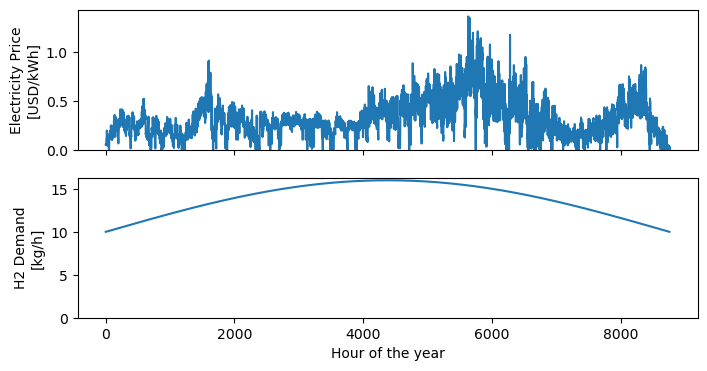

In [4]:
# Plot the electricity prices, and the demand profile
fig, ax = plt.subplots(2, figsize=(8,4), sharex=True)

ax[0].plot(grid_price_hourly__usd_per_kwh, label="Electricity price")
ax[0].set_ylabel("Electricity Price\n[USD/kWh]")

ax[1].plot(h2_demand__kg_per_hour, label="Hydrogen demand")
ax[1].set_xlabel("Hour of the year")
ax[1].set_ylabel("H2 Demand\n[kg/h]")

# Begin the y axis at zero
ax[0].set_ylim(bottom = 0)
ax[1].set_ylim(bottom = 0)


In [5]:
# Run the hydrogen production model with unoptimized parameters
electrolyzer_capacity_factor__fraction = np.ones((8760,)) * 0.5
electrolyzer_size__mw =3.0

lcoh, _, _, _, _, _, _ = hydrogen_supply_cost(
        h2_demand__kg_per_hour = h2_demand__kg_per_hour,
        electricity_price__usd_per_kwh = grid_price_hourly__usd_per_kwh,
        electrolyzer_size__mw = electrolyzer_size__mw,
        electrolyzer_capacity_factor__fraction = electrolyzer_capacity_factor__fraction
    )

print("Unoptimized LCOH:", lcoh)

Unoptimized LCOH: 35.467224


In [6]:
# In the current implementation, the optimization runs significantly faster on a CPU than on a GPU.
# This is because the overhead of moving data to and from the GPU outweighs the benefits
# of parallel computation on the GPU for this particular problem.
# To harness the benefits of GPU acceleration, the optimization problem could be expanded to
# solve batches of related problems simultaneously,
# for example by optimizing the hydrogen production costs for multiple locations simultaneously.

# Select the device to run the optimization on (CPU or GPU).
device_type = 'cpu'
device = jax.devices(device_type)[0]
print("Device:", device)

# Move data to the selected device
h2_demand__kg_per_hour = jax.device_put(h2_demand__kg_per_hour, device=device)
grid_price_hourly__usd_per_kwh = jax.device_put(grid_price_hourly__usd_per_kwh, device=device)
electrolyzer_size__mw = jax.device_put(electrolyzer_size__mw, device=device)
electrolyzer_capacity_factor__fraction = jax.device_put(electrolyzer_capacity_factor__fraction, device=device)

# Create a tuple of arguments to pass to the function for better readability
args = (
    h2_demand__kg_per_hour,
    grid_price_hourly__usd_per_kwh,
    electrolyzer_size__mw,
    electrolyzer_capacity_factor__fraction 
)

Device: TFRT_CPU_0


In [7]:
# Demonstrate that JAX can accelerate the optimization by comparing the time to optimize the function
# before and after just-in-time compiling the python code to XLA.

# First, time the execution time without JIT compilation. Note the result in milliseconds.

%timeit hydrogen_supply_cost(*args)[0].block_until_ready()

26.8 ms ± 1.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
# Next, time the execution time with JIT compilation. Note the result in microseconds.
hydrogen_supply_cost_jitted = jax.jit(hydrogen_supply_cost)

%timeit hydrogen_supply_cost_jitted(*args)[0].block_until_ready()

67.1 μs ± 153 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [9]:
# Optimize the hydrogen production model using gradient descent

# Set the number of iterations for the optimization
iterations = 10000
max_iterations_without_improvement = iterations * 0.025

# Define separate starting learning rates for each parameter
learning_rate_electrolyzer_size = 0.1
learning_rate_capacity_factor = 0.01

# Decay the learning rate after max_iterations_without_improvement
learning_rate_decay = .5

# Create separate optimizers so that we can use different learning rates for each parameter
def create_optimizer(learning_rate_electrolyzer_size, learning_rate_capacity_factor):
    optimizer_electrolyzer_size = optax.chain(
        optax.scale_by_adam(),
        optax.scale(-learning_rate_electrolyzer_size)
    )
    optimizer_capacity_factor = optax.chain(
        optax.scale_by_adam(),
        optax.scale(-learning_rate_capacity_factor)
    )
    return optimizer_electrolyzer_size, optimizer_capacity_factor

# Initialize the optimizers
optimizer_electrolyzer_size, optimizer_capacity_factor = create_optimizer(learning_rate_electrolyzer_size, learning_rate_capacity_factor)

# Initialize parameters of the model + optimizers.
fixed_inputs = (h2_demand__kg_per_hour, grid_price_hourly__usd_per_kwh)
params_to_optimize = (electrolyzer_size__mw, electrolyzer_capacity_factor__fraction)

opt_state_size = optimizer_electrolyzer_size.init(electrolyzer_size__mw)
opt_state_capacity = optimizer_capacity_factor.init(electrolyzer_capacity_factor__fraction)

# Create a wrapper function that only returns the LCOH
@jax.jit
def hydrogen_supply_cost_wrapper(
        h2_demand__kg_per_hour,
        grid_price_hourly__usd_per_kwh,
        electrolyzer_size__mw,
        electrolyzer_capacity_factor__fraction
    ):
    lcoh, _, _, _, _, _, _ = hydrogen_supply_cost(
            h2_demand__kg_per_hour,
            grid_price_hourly__usd_per_kwh,
            electrolyzer_size__mw,
            electrolyzer_capacity_factor__fraction
            )
    return lcoh

# Create a list to store the history of LCOH values during optimization
lcoh_history = []

# Create a variabel to track the best cost found so far
best_lcoh = lcoh
best_params = params_to_optimize

# Store the number of iterations without improvement so that we can adjust the learning rate
iterations_without_improvement = 0

for i in range(iterations):

    tic = time.time()

    # Compute the gradient of LCOH with respect to electrolyzer size and capacity factor
    grads = jax.grad(hydrogen_supply_cost_wrapper, argnums=[2,3])(*fixed_inputs, *params_to_optimize)

    # Update electrolyzer size
    updates_size, opt_state_size = optimizer_electrolyzer_size.update(grads[0], opt_state_size)
    electrolyzer_size__mw = optax.apply_updates(params_to_optimize[0], updates_size)

    # Update capacity factor
    updates_capacity, opt_state_capacity = optimizer_capacity_factor.update(grads[1], opt_state_capacity)
    electrolyzer_capacity_factor__fraction = optax.apply_updates(params_to_optimize[1], updates_capacity)

    # Make sure we don't exceed minimum and maximum values
    electrolyzer_size__mw = electrolyzer_size__mw.clip(min=0, max=1e3)
    electrolyzer_capacity_factor__fraction = electrolyzer_capacity_factor__fraction.clip(min=0, max=1)
    params_to_optimize = (electrolyzer_size__mw, electrolyzer_capacity_factor__fraction)

    # Evaluate the lcoh with the current paramaters
    lcoh = hydrogen_supply_cost_wrapper(*fixed_inputs, *params_to_optimize)

    # Update the best_lcoh and best_params if we found a new minimum
    if lcoh < best_lcoh:
        best_lcoh = lcoh
        best_params = params_to_optimize
        iterations_without_improvement = 0
    else:
        iterations_without_improvement += 1
        
    if iterations_without_improvement == max_iterations_without_improvement:
        # Apply learning rate decay
        learning_rate_electrolyzer_size *= learning_rate_decay
        learning_rate_capacity_factor *= learning_rate_decay

        # Recreate the optimizers with the new learning rates
        optimizer_electrolyzer_size, optimizer_capacity_factor = create_optimizer(learning_rate_electrolyzer_size, learning_rate_capacity_factor)
        
        iterations_without_improvement = 0
    
    # Save the best params if we reached the last iteration
    if i + 1 == iterations:
            (electrolyzer_size__mw, electrolyzer_capacity_factor__fraction) = best_params
    
    # Store the results in the history
    lcoh_history.append(lcoh)
    
    toc = time.time()
    iteration_time = toc - tic
    
    # Print the results during the optimization process
    display.clear_output(wait=False)
    print(f"Iteration:\t\t\t\t\t{i}", flush=True)
    print(f"Iterations without improvement:\t\t\t{iterations_without_improvement} of max: {max_iterations_without_improvement:0.0f}", flush=True)
    print(f"Best LCOH:\t\t\t\t\t{best_lcoh:0.4f} $/kg", flush=True)
    print(f"Current LCOH:\t\t\t\t\t{lcoh:0.4f} $/kg", flush=True)
    print(f"Current Electrolyzer size:\t\t\t{params_to_optimize[0]:0.2f} MW", flush=True)
    print(f"Current Mean CF:\t\t\t\t{np.mean(params_to_optimize[1]*100):0.4f} %", flush=True)
    print(f"Current learning rate Electrolyzer size:\t{learning_rate_electrolyzer_size:0.10f}", flush=True)
    print(f"Current learning rate Capacity Factor:\t\t{learning_rate_capacity_factor:0.10f}", flush=True)
    print(f"Time per iteration:\t\t\t\t{iteration_time*1000:0.0f} milliseconds", flush=True)

Iteration:					9999
Iterations without improvement:			24 of max: 250
Best LCOH:					13.9440 $/kg
Current LCOH:					13.9441 $/kg
Current Electrolyzer size:			4.21 MW
Current Mean CF:				21.6096 %
Current learning rate Electrolyzer size:	0.0000976563
Current learning rate Capacity Factor:		0.0000097656
Time per iteration:				5 milliseconds


Text(0.5, 0.98, 'Learning curve')

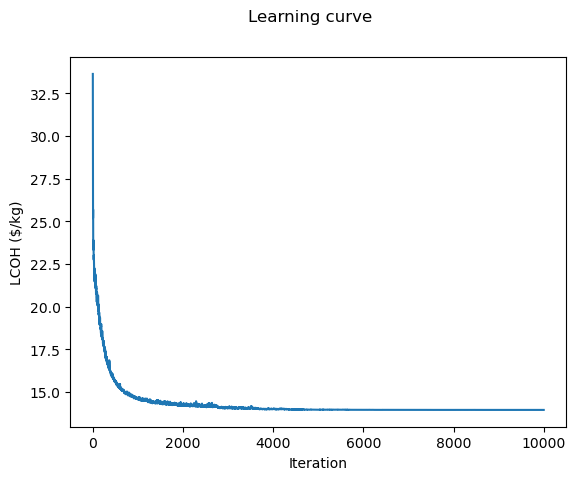

In [10]:
# Plot the LCOH history across iterations
fig, ax = plt.subplots()
ax.plot(lcoh_history)
ax.set_xlabel("Iteration")
ax.set_ylabel("LCOH ($/kg)")

# Add a title to the figure
fig.suptitle("Learning curve")

In [11]:
# Run the model with the optimal electrolyzer size and capacity factors
lcoh, h2_absolute_storage_level__kg, annual_h2_deficit__ratio, h2_deficit__kg_per_hour, h2_surplus__kg_per_hour, h2_production__kg_per_hour, h2_storage_charge_and_discharge__kg_per_hour = hydrogen_supply_cost(
    h2_demand__kg_per_hour,
    grid_price_hourly__usd_per_kwh,
    electrolyzer_size__mw,
    electrolyzer_capacity_factor__fraction)

print(f"Optimal LCOH:\t {lcoh:0.4f} $/kg")

Optimal LCOH:	 13.9440 $/kg


Text(0.5, 0.98, 'Electrolyzer operation')

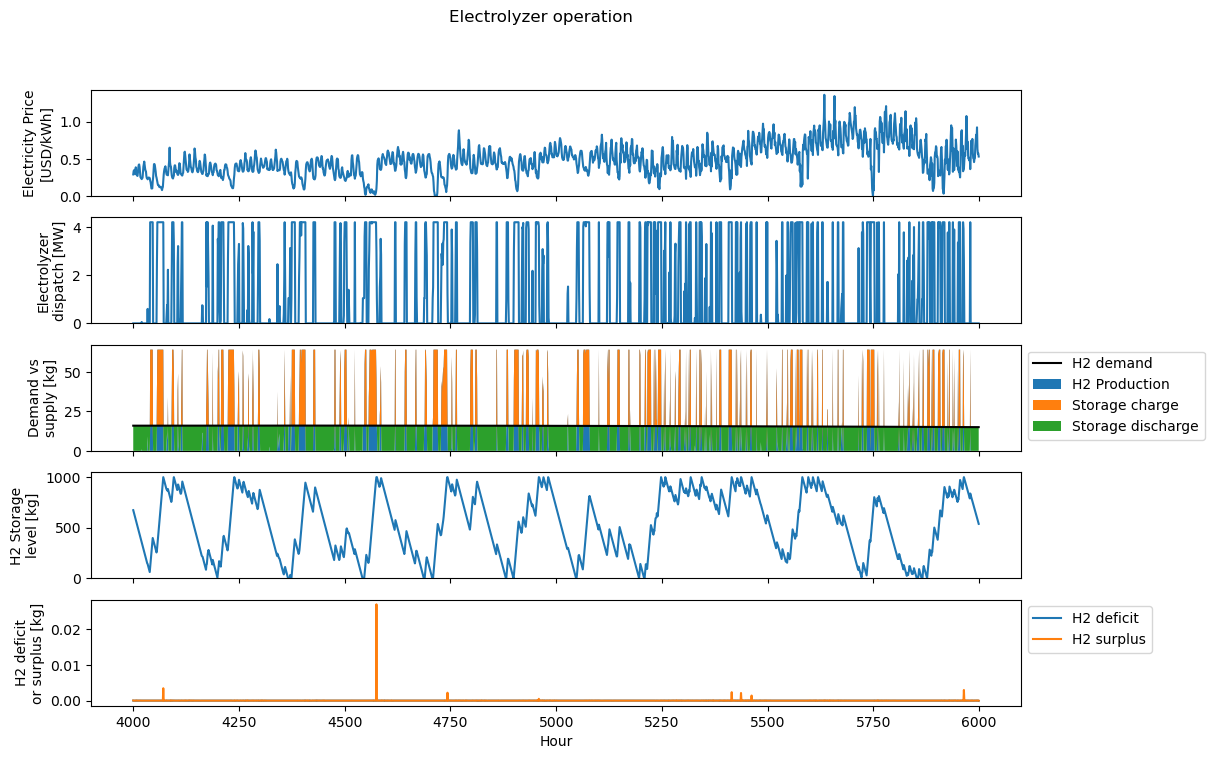

In [12]:
# Plot the results of the optimization
fromhour = 4000
tohour = 6000

hour_range = range(8760)[fromhour:tohour]

fig, ax = plt.subplots(5, figsize=(12,8), sharex=True)

ax[0].plot(hour_range, grid_price_hourly__usd_per_kwh[fromhour:tohour])
ax[1].plot(hour_range, electrolyzer_size__mw * electrolyzer_capacity_factor__fraction[fromhour:tohour])
ax[2].plot(hour_range, h2_demand__kg_per_hour[fromhour:tohour], label='H2 demand', color='black')
ax[2].stackplot(
    hour_range,
    [
        h2_production__kg_per_hour[fromhour:tohour],
        -np.maximum(h2_storage_charge_and_discharge__kg_per_hour[fromhour:tohour], 0),
        -np.minimum(h2_storage_charge_and_discharge__kg_per_hour[fromhour:tohour], 0),
    ],
    labels=['H2 Production', 'Storage charge', 'Storage discharge']
    )
ax[2].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[3].plot(hour_range, h2_absolute_storage_level__kg[fromhour:tohour])
ax[4].plot(hour_range, h2_deficit__kg_per_hour[fromhour:tohour], label='H2 deficit')
ax[4].plot(hour_range, h2_surplus__kg_per_hour[fromhour:tohour], label='H2 surplus')
ax[4].legend(loc='upper left', bbox_to_anchor=(1, 1))


# Add axis labels
ax[0].set_ylabel('Electricity Price\n[USD/kWh]')
ax[1].set_ylabel('Electrolyzer\ndispatch [MW]')
ax[2].set_ylabel('Demand vs\nsupply [kg]')
ax[3].set_ylabel('H2 Storage\nlevel [kg]')
ax[4].set_ylabel('H2 deficit\nor surplus [kg]')

ax[4].set_xlabel('Hour')

ax[0].set_ylim(bottom = 0)
ax[1].set_ylim(bottom = 0)
ax[3].set_ylim(bottom = 0)

# Add a title to the figure
fig.suptitle("Electrolyzer operation")